**KUDAGO categories relation**

Goal - to estimate relations between different kudago categories.

to do: adjust delimiter for tags, analyze multiple categories events


In [1]:
#connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#read dataset
import pandas as pd
DATA0 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/403-497_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA1 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/1-402_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA2 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/497-1653_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA = pd.concat([DATA0,DATA1,DATA2])

In [3]:
print('Events amount', DATA.shape[0])

Events amount 165565


#First step: analyzing event tags



# Preprocessing

In [4]:
#cut the table
df = DATA[['Category', 'Event tag']]

In [5]:
#checking what kind of categories we have
df.groupby(['Category']).count()


,Event tag
Category,
business-events,476
"business-events,entertainment",6
"business-events,festival",17
"business-events,festival,entertainment",1
"business-events,festival,recreation",1
...,...
"tour,recreation,entertainment",5
"tour,yarmarki-razvlecheniya-yarmarki,entertainment",3
yarmarki-razvlecheniya-yarmarki,5


Firstly, let's not use events of multiple categories


In [6]:
#checking how many events we have for each category
df_new = df[~df['Category'].str.contains(',', na=False)]
df_new.groupby(['Category']).count()

,Event tag
Category,
business-events,476
cinema,106
concert,56347
education,10641
entertainment,2625
exhibition,15125
fashion,125
festival,4040
holiday,835


In [7]:
#concatenation of all tags for each category
df_grouped_full = df_new.groupby(['Category']).apply(lambda x: ','.join(x['Event tag']))

In [8]:
#here we remove categories of kudago, which we will not use for events detecting task
deleted_cats =  ['quest', 'yarmarki-razvlecheniya-yarmarki','other','stock']
df_grouped = df_grouped_full.drop(deleted_cats, axis=0)
df_grouped

Category
business-events    12+,события для бизнеса,события для бизнеса,со...
cinema             кинопоказы,12+,кино (развлечения),кино (развле...
concert            рэп и хип-хоп,концерты,16+,концерты,альтернати...
education          обучение,16+,лучшее,искусство,обучение,12+,рис...
entertainment      игры,развлечения,16+,шоу,лучшее в театрах,разв...
exhibition         выставки,картины, живопись, графика,выставки,к...
fashion            мода и стиль,шоурумы,красота и здоровье,тренин...
festival           фестивали,городские,free,культура и искусство,...
holiday            животные,тематические праздники,выходные,празд...
kids               12+,детские лагеря,лучшее в мае,детям,детские ...
party              18+,танцевальная,вечеринки,электронная музыка,...
photo              животные,фотография,интересное,всей семьей,fre...
recreation         отдых,18+,спорт и фитнес,хоккей,6+,отдых,отдых...
shopping           шопинг (магазины),free,шопинг (магазины),книги...
social-activity    благот

#Summary Table Creation

In [9]:
#the next cell is very time expensive, we check if we have a file with it
import os
check_file = False
if os.path.exists('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl'):
  check_file = True
  df_final = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl')
check_file

True

In [10]:
#We want to know which tags (rows) were used for which categories (columns) and how many times (data in cells)
#To do it we create DataFrame from the dict of subdicts: one subdict for one category, each subdict maps tag to number of tag's usages 
if check_file == False:
  dict_lists = dict()
  for index in df_grouped.index:
    temp = df_grouped.get(index).rsplit(',')
    one_dict = {i:temp.count(i) for i in temp}
    dict_lists[index]=(one_dict)
  #final statistics DataFrame
  df_final = pd.DataFrame(dict_lists).fillna(0)
else:
  print('File was found')

File was found


In [11]:
df_final

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
12+,12.0,10.0,10786.0,1526.0,207.0,971.0,4.0,283.0,15.0,36.0,22.0,1.0,210.0,0.0,3.0,3661.0,602.0
события для бизнеса,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18+,167.0,67.0,14700.0,1932.0,556.0,401.0,11.0,427.0,39.0,0.0,3527.0,3.0,176.0,0.0,19.0,1978.0,150.0
free,135.0,29.0,2594.0,2681.0,356.0,4051.0,29.0,1653.0,315.0,122.0,1177.0,12.0,348.0,42.0,81.0,435.0,164.0
16+,70.0,11.0,11108.0,2094.0,286.0,454.0,14.0,303.0,9.0,0.0,123.0,0.0,128.0,4.0,7.0,5364.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
погода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
эзотерика,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
блошиные рынки,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ярмарки (развлечения,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#save dataframe to file
if check_file == False:
  df_final.to_pickle("/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl")
else:
  print('File exists')

File exists


#Visualisation with supervenn


In [13]:
#visualize data with method from https://habr.com/ru/company/yandex/blog/501924/
!pip install supervenn

In [14]:
#labels are categories
labels = list(df_final.columns)
#sets are tags
sets = []
for index in df_grouped.index:
  temp = df_grouped.get(index).rsplit(',')
  sets.append(set(temp))

In [15]:
#to find intersections of categories we don't consider unique tags
new_sets = []
for i in range(len(sets)):
  temp_list = []
  for j in range(len(sets)):
    #avoiding comparing with the same set
    if i == j:
      continue
    #we collect not unique tags into list
    temp_list.extend(sets[i] & sets[j])
  #now we need to convert our collection to set
  new_sets.append(set(temp_list))

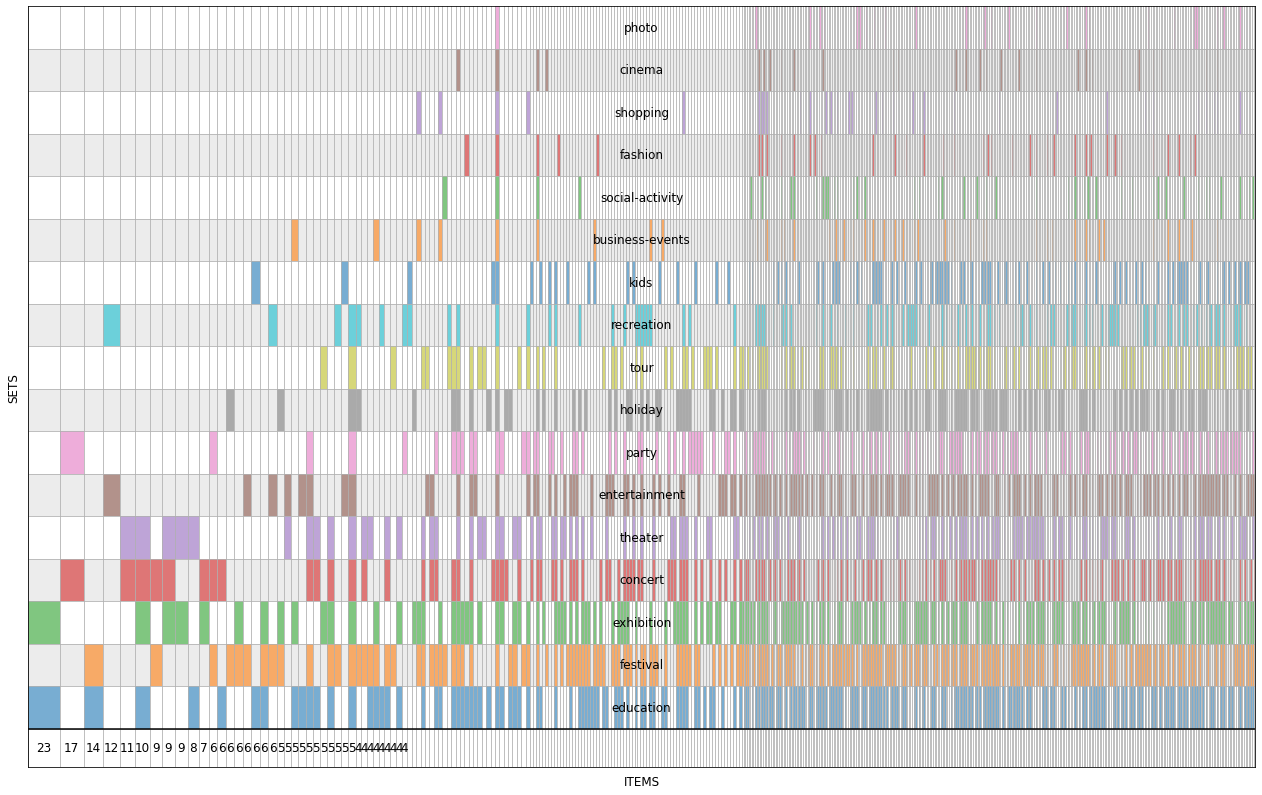

In [16]:
import matplotlib.pyplot as plt
from supervenn import supervenn
plt.figure(figsize=(22, 14))
visual0 = supervenn(new_sets, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

# Visualisation for unique tags

Results are good, but not so clean, let's firstly delete very frequent tags (appears more than in 5 categories)

In [17]:
#here we check in how many categories the particular tag appears, and delete very frequent tags
import copy
new_sets_cut = copy.deepcopy(new_sets)

#for all sets
for i in range(len(new_sets)):
  #check all tags
  for j in new_sets[i]:
    counter = 0
    #check for all other sets except the same one
    for k in range(len(new_sets)):
      if k == i:
        continue
      if j in new_sets[k]:
        counter += 1
    if counter > 5:
      new_sets_cut[i].remove(j)

In [18]:
#amount of unique/not unique tags
print('unique\t common\t total')
for i in range(len(new_sets_cut)):
  print('{}\t :{}\t  :{}\t :{}'.format(len(sets[i])-len(new_sets_cut[i]), len(new_sets_cut[i]), len(sets[i]), labels[i]))

unique	 common	 total
27	 :36	  :63	 :business-events
29	 :8	  :37	 :cinema
153	 :241	  :394	 :concert
179	 :316	  :495	 :education
143	 :178	  :321	 :entertainment
170	 :271	  :441	 :exhibition
32	 :18	  :50	 :fashion
162	 :309	  :471	 :festival
114	 :131	  :245	 :holiday
74	 :85	  :159	 :kids
106	 :153	  :259	 :party
19	 :11	  :30	 :photo
122	 :100	  :222	 :recreation
24	 :19	  :43	 :shopping
41	 :18	  :59	 :social-activity
150	 :201	  :351	 :theater
116	 :109	  :225	 :tour


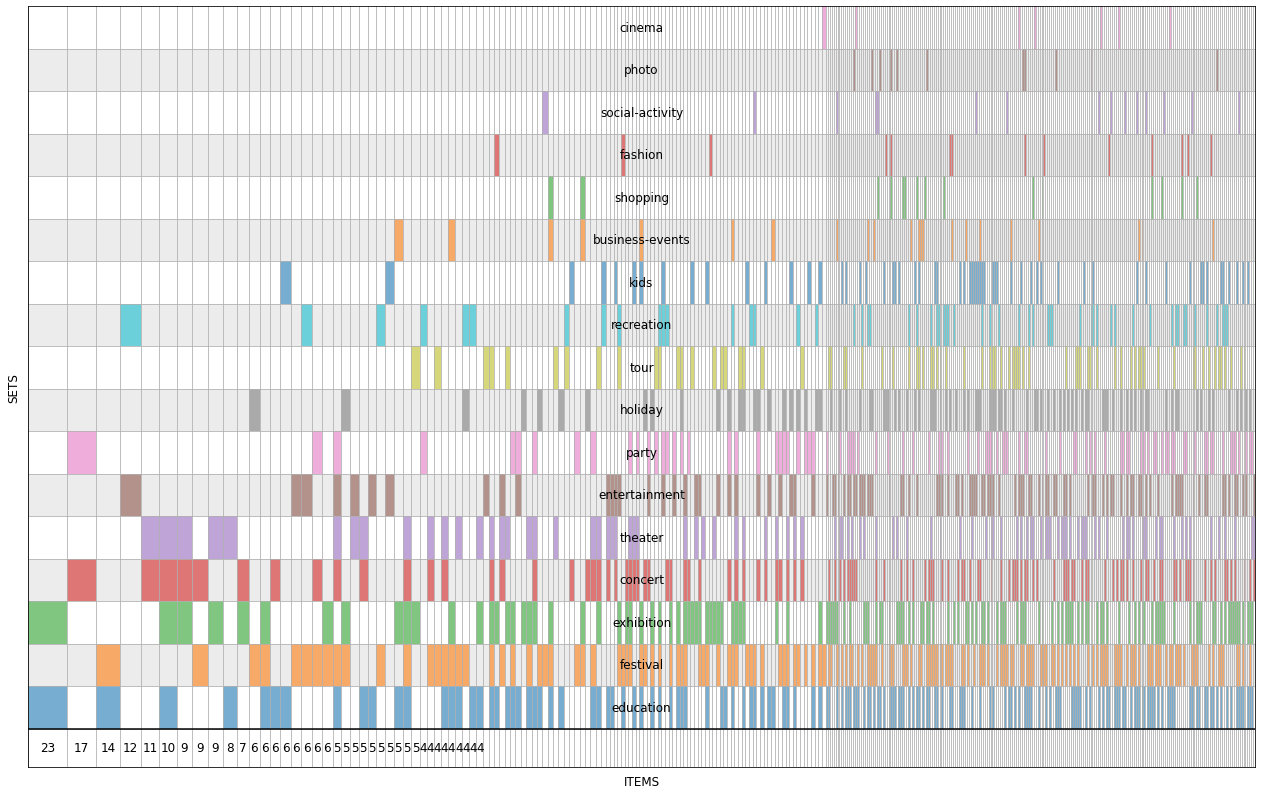

In [19]:
plt.figure(figsize=(22, 14))
visual = supervenn(new_sets_cut, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

In [20]:
#example of extracting common tags
print(visual.chunks[frozenset([labels.index('education'), labels.index('exhibition')])])
print(visual.chunks[frozenset([labels.index('party'), labels.index('concert')])])

{'витражи', 'cобаки', 'концептуальное искусство', 'аналоговая фотография', 'bibliophilia', 'акварель', 'арт-объекты', 'гравюра', 'эпоха возрождения', 'бижутерия', 'мэрилин монро', 'батик', 'мозаика', 'скрапбукинг', 'изобретения', 'голландия', 'александр васильев', 'декупаж', 'обучение за рубежом', 'парфюмерия', 'архитектура', 'будущее', 'абстрактное искусство'}
{'rnb', 'душевно', 'диско', 'тяжелый рок', 'майкл джексон', 'witch house', 'клубная жизнь', 'эмбиент', 'дискотека 90х', 'дискотека 80х', 'драм-н-бэйс', 'день первокурсника', 'r&b', 'рейв', 'glitch', 'хардкор техно', 'виниловые пластинки'}


#Second step: analyzing events of multiple categories

Here we want to analyze which categories have common events (by extracting events with multiple categories)

In [21]:
df_multiple =  df[df['Category'].str.contains(',', na=False)]
print('Amount of events with multiple categories', df_multiple.shape[0])

Amount of events with multiple categories 41354


In [22]:
#we create an array of two dims and remeber how many times each category was with another one
n = len(df_grouped_full.index)
group_list = list(df_grouped_full.index)
cats_inter = [[0] * n for i in range(n)]
for event in df_multiple['Category']:
  cats = event.rsplit(',')
  for i in range(len(cats)):
    for j in range(len(cats)):
      if i != j:
        cats_inter[group_list.index(cats[j])][group_list.index(cats[i])] += 1

In [23]:
df_step2 = pd.DataFrame(cats_inter, columns=group_list, index=group_list).fillna(0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=1)
df_step2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0,0,4,682,29,72,6,51,0,9,2,1,6,1,2,0,1
cinema,0,0,143,683,5634,78,15,1139,60,165,344,3,19,2,26,194,21
concert,4,143,0,1110,1809,137,13,2488,354,1119,1917,5,166,14,288,1111,57
education,682,683,1110,0,1943,674,551,1276,434,2233,476,117,697,58,226,540,368
entertainment,29,5634,1809,1943,0,905,152,3067,977,2147,1229,59,897,272,334,1220,280
exhibition,72,78,137,674,905,0,173,636,97,744,88,447,45,38,182,67,261
fashion,6,15,13,551,152,173,0,93,29,21,40,21,13,91,11,8,2
festival,51,1139,2488,1276,3067,636,93,0,875,1546,674,61,649,44,362,521,174
holiday,0,60,354,434,977,97,29,875,0,1296,687,19,194,57,75,308,126
kids,9,165,1119,2233,2147,744,21,1546,1296,0,154,31,375,34,237,4253,498


We can see a number of events with common categories, but the table does not include total number of events for each category. In other words, if only 1 event of "shopping" out of 1000 is also marked as "business-event" it shows very weak correlation, however, if we have the same result with 1 event of "shopping" out of 2 events it is interesting to know.

In [24]:
#here we transform our table from 'number' to 'percentege' by taking into account a total number of events for each category
#we divide each column by the number of events and multiply 100 to find a percentege
for cat in df_step2.index:
  count = df[df['Category'].str.contains(cat, na=False)].count()[0]
  df_step2[cat] = df_step2[cat].apply(lambda x: x/count*100)

In [25]:
#let's highlight large percentege values to see the results better
def style_large_values(v, props=''):
    return props if v > 30 else None
s2 = df_step2.style.applymap(style_large_values, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 5) else None)
s2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0.000000,0.000000,0.006132,3.461578,0.152768,0.384656,0.561272,0.380370,0.000000,0.074044,0.022696,0.138504,0.127578,0.142248,0.129702,0.000000,0.023602
cinema,0.000000,0.000000,0.219214,3.466653,29.679187,0.416711,1.403181,8.494928,1.355932,1.357466,3.903768,0.415512,0.403997,0.284495,1.686122,0.931573,0.495634
concert,0.314713,2.473620,0.000000,5.633946,9.529579,0.731916,1.216090,18.556086,8.000000,9.206088,21.754426,0.692521,3.529662,1.991465,18.677043,5.334934,1.345291
education,53.658537,11.814565,1.701593,0.000000,10.235474,3.600812,51.543499,9.516706,9.807910,18.371041,5.401725,16.204986,14.820327,8.250356,14.656291,2.593037,8.685391
entertainment,2.281668,97.457187,2.773136,9.861943,0.000000,4.834918,14.218896,22.874403,22.079096,17.663513,13.946891,8.171745,19.072932,38.691323,21.660182,5.858343,6.608449
exhibition,5.664831,1.349248,0.210016,3.420972,4.767423,0.000000,16.183349,4.743437,2.192090,6.120938,0.998638,61.911357,0.956836,5.405405,11.802853,0.321729,6.160019
fashion,0.472069,0.259471,0.019929,2.796670,0.800716,0.924244,0.000000,0.693616,0.655367,0.172768,0.453926,2.908587,0.276419,12.944523,0.713359,0.038415,0.047203
festival,4.012589,19.702474,3.814021,6.476500,16.156561,3.397799,8.699719,0.000000,19.774011,12.719046,7.648661,8.448753,13.799702,6.258890,23.476005,2.501801,4.106679
holiday,0.000000,1.037883,0.542670,2.202822,5.146710,0.518218,2.712816,6.525955,0.000000,10.662279,7.796187,2.631579,4.125027,8.108108,4.863813,1.478992,2.973802
kids,0.708104,2.854177,1.715389,11.333875,11.310120,3.974784,1.964453,11.530430,29.288136,0.000000,1.747617,4.293629,7.973634,4.836415,15.369650,20.422569,11.753599


Now we can easily find some trends:
*   53% events of 'business-events' are also 'education'
*   97% events of 'cinema' are also 'entertainment'
*   61% events of 'photos' are also 'exhibition'
*   and so on.. 